In [59]:
import numpy as np
import pylab as plt
import inspect
from math import log10
from pymc import *
from collections import OrderedDict as OD
from scipy.interpolate import interp1d as interp
from scipy.optimize import brentq, minimize_scalar
from profiles import build_profile, build_kernel
from dispersion import SphericalJeansDispersion
from likelihood import GaussianLikelihood
#from fitter import *

%matplotlib inline

In [2]:
directory = '/home/andrea/Desktop/work/DWARF/'
rh = 0.04
D = 39.81
theta = 2*rh/D

In [3]:
dm = build_profile('NFW')
st = build_profile('plummer',**{'rh':rh}) # Plummer Stellar profile
kr = build_kernel('iso') # isotropic kernel
dwarf_props = {'D':D, 'theta':theta, 'rt':np.inf, 'with_errs':False}
Sigma = SphericalJeansDispersion(dm, st, kr, dwarf_props)

In [4]:
R, v = np.loadtxt(directory+'dsphsim/Ret2_data/dsph_001.txt',usecols=(5, 7),unpack=True)
#R, v = np.load('results/equiRdSphs.npy')
vnan = np.isnan(v)
v = v[:100]#[~vnan]
R = R[:100]#[~vnan]
dv = np.zeros_like(v)

In [5]:
LL = GaussianLikelihood([R, v, dv, 0.], Sigma)

In [6]:
LL.set_free('dm_a')
LL.set_free('dm_b')
LL.set_free('dm_c')
LL.set_free('dm_r0')

$r_s = 0.35 , \rho_s = 7.55 \times 10^7 , J = 16.72$

In [7]:
Lpars = LL.free_pars.keys()
LL.free_pars.keys()

['dm_a', 'dm_b', 'J', 'dm_r0', 'dm_c']

$f(x \mid \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}$

In [51]:
dic = {'J': 5, 'a': 1, 'b': 2, 'c': 3, 'r': 4}
Lpars = ['dm_a', 'dm_b', 'J', 'dm_r0', 'dm_c']

In [63]:
dict( zip( sorted(Lpars), OD(sorted(dic.items(), key=lambda x: x[0])).values() ) )

[('J', 5), ('dm_a', 1), ('dm_b', 2), ('dm_c', 3), ('dm_r0', 4)]

In [77]:
def model(J):
    #J = Uniform('J', lower=15, upper=19)
    r = Uniform('r', lower=-3., upper=2.)
    a = Uniform('a', lower=.5, upper=3.)
    b = Uniform('b', lower=2., upper=6.)
    c = Uniform('c', lower=0., upper=1.2)
    
    @deterministic
    def sigma(a=a, b=b, c=c, r=10**r, J=J):
        frame = inspect.currentframe()
        argvals = inspect.getargvalues(frame)[3]
        argvals.pop('frame')
        print argvals
        new_vals = zip(sorted(Lpars), OD(sorted(argvals.items(), key=lambda x: x[0])).values())
        for name,value in new_vals:
            print name, value
            Sigma.setparams(name, value)
        return dv**2 + Sigma.compute(R)
    
    @deterministic
    def loglike(J=J, a=a, b=b, c=c, r=r):
        return LL(a, b, J, 10**r, c)
    
    
    v_obs = Normal('v', mu=v.mean(), tau=1/sigma, value=v, observed=True)
    
    return locals()

In [78]:
M = MCMC( model(16) )

{'a': array(2.2938677975473487), 'c': array(0.9379100776046305), 'b': array(5.709673028836438), 'J': 16, 'r': 0.022742881814812061}
J 16
dm_a 2.29386779755
dm_b 5.70967302884
dm_c 0.937910077605
dm_r0 0.0227428818148


In [79]:
M.sample( iter=2, verbose=3)


Burn-in interval complete
Step method Metropolis_c stepping

Metropolis_c getting initial logp.
	Metropolis_c Current log-likelihood plus current log-probability -918.676316029
Metropolis_c proposing.
Metropolis_c rejecting due to ZeroProbability.
Metropolis_c returning.
Step method Metropolis_r stepping

Metropolis_r getting initial logp.
	Metropolis_r Current log-likelihood plus current log-probability -920.103432384
Metropolis_r proposing.
Metropolis_r rejecting due to ZeroProbability.
Metropolis_r returning.
Step method Metropolis_a stepping

Metropolis_a getting initial logp.
	Metropolis_a Current log-likelihood plus current log-probability -919.410285204
Metropolis_a proposing.
Metropolis_a rejecting due to ZeroProbability.
Metropolis_a returning.
Step method Metropolis_b stepping

Metropolis_b getting initial logp.
	Metropolis_b Current log-likelihood plus current log-probability -919.880288833
Metropolis_b proposing.
Metropolis_b rejecting due to ZeroProbability.
Metropolis_b 

In [31]:
L = M.trace('loglike')[:]

Lnan = np.logical_or(np.isnan(L), np.isinf(L))
L = L[~Lnan]

indLmin = np.where( L==min(L) )[0][0]
Lmin = L[indLmin]

for par in ['a', 'b', 'c', 'r']:
    exec( "{p} = M.trace('{p}')[~Lnan]".format(p=par) )

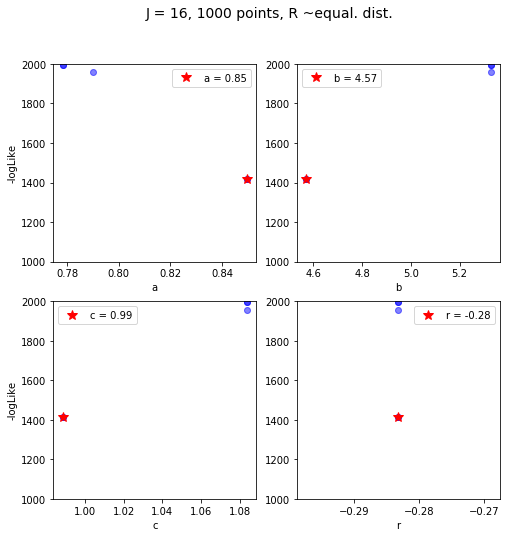

In [32]:
fig = plt.figure(figsize=(8,8))
for i,par in enumerate(['a', 'b', 'c', 'r']):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot( eval('{}'.format(par)), L, 'bo', alpha=0.2  );
    exec( 'parmin = {}[indLmin]'.format(par) )
    ax.plot( parmin, L[indLmin], 'r*', ms=10, label= '%s = %.2f'%(par, parmin) );
    ax.set_xlabel(par);
    if i%2 == 0: 
        ax.set_ylabel('-logLike')
    ax.set_ylim(1e3, 2e3);
    ax.legend(numpoints=1);
plt.suptitle('J = 16, 1000 points, R ~equal. dist.', fontsize=14);
#plt.savefig('results/Likeparams_Mc1000_J16_equiR.png', dpi=300, format='png');

In [16]:
interp_L = interp(J_array, L_arr-L_arr.min())
interp_r = interp(J_array, r_arr)
interp_a = interp(J_array, a_arr)
interp_b = interp(J_array, b_arr)
interp_c = interp(J_array, c_arr)

In [17]:
eval_Like_J = np.linspace(J_array.min(), J_array.max(), 1e3)
min_Like_J = interp_L(eval_Like_J).min()
Jmin = eval_Like_J[ np.where( interp_L(eval_Like_J) == min_Like_J )[0][0] ]
J_plt = np.linspace(J_array.min(),J_array.max())

In [18]:
Jr = float(interp_r(Jmin))
Ja = float(interp_a(Jmin))
Jb = float(interp_b(Jmin))
Jc = float(interp_c(Jmin))

In [53]:
dm.r0 = Jr
dm.a = Ja
dm.b = Jb
dm.c = Jc
minrho = lambda rho : float(abs(Jmin - log10( dm.Jfactor(**dwarf_props) ) - 2*rho))
Jrho = 10**minimize_scalar(minrho).x

In [54]:
print 'J = %2.2f, r = %2.2f, rho = %2.2e, a = %2.2f, b = %2.2f , c = %2.2f'%(Jmin, Jr, Jrho, Ja, Jb ,Jc)

J = 16.00, r = 0.11, rho = 2.12e+08, a = 4.03, b = 2.77 , c = 0.83


In [23]:
for i,c in enumerate([0.5,2.0,4.5]):
    exec('J%ssL = %.2f'%(i+1, brentq(lambda j : interp_L(j)-c, J_array.min(), Jmin) - Jmin))
    exec('J%ssR = %.2f'%(i+1, brentq(lambda j : interp_L(j)-c, Jmin, J_array.max()) - Jmin))

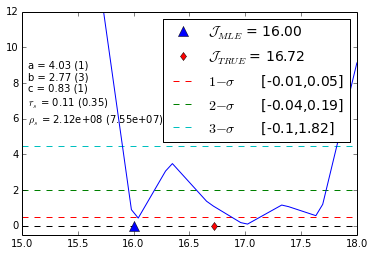

In [60]:
plt.plot(J_plt, interp_L(J_plt))
plt.hlines(0, J_plt.min(), J_plt.max(), linestyles='dashed')
plt.plot(Jmin, 0, 'b^', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin)
plt.plot(16.72, 0, 'rd', markersize=6, label=r'$\mathcal{J}_{TRUE}$ = 16.72')
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5,2.0,4.5])):
    JL, JR = eval('J%ssL'%str(i+1)), eval('J%ssR'%str(i+1))
    plt.hlines(h, J_plt.min(), J_plt.max(), linestyles='dashed', colors=c,
              label=r'$%i-\sigma$'%(i+1)+'\t'+'[%2s,%2s]'%(str(JL),str(JR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.text(15.05, 5,'a = %.2f (1)'%Ja +'\n'+
                 'b = %.2f (3)'%Jb +'\n'+
                 'c = %.2f (1)'%Jc +'\n'+
                 r'$r_s$ = %.2f (0.35)'%Jr +'\n'+
                 r'$\rho_s$ = %.2e (7.55e+07)'%Jrho +'\n')

plt.ylim(-0.5,12);
#plt.savefig('results/LikeJ_10p_Mcmc.png',format='png',dpi=300);